
# Seis2Rock - Volve Dataset <br> 
## Petrophysical Inversion on the Fence along well NO 15 9-19 BT2



This notebook provides an illustration of the petrophysical inversion carried out on the Fence along Well NO 15 9-19 BT2. It showcases the required data and the Seis2Rock methodology used for the inversion process. In this notebook, we only use the well log information of the well NO 15 9-19 BT2.

In [1]:

%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt

import pylops
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.avo.avo                    import *
from pylops.avo.poststack              import *
from pylops.avo.prestack               import *
from pylops.optimization.leastsquares  import *
from scipy.ndimage import gaussian_filter
from scipy.ndimage.interpolation import shift

from seis2rock.seis2rock_functions import *
from seis2rock.seis2rock_utils import *

np.random.seed(5)

## Loading and visualizing data needed

In [2]:
f = np.load('../../data/Volve2dfenceby1degree_NO_15_9-19_BT2.npz', 
            allow_pickle=True) 

f.files

['t_seis',
 'z_vel',
 't_vrms',
 't_ainvt',
 'seismict_fence',
 'vtraces',
 'vtraces_z',
 'well_prestack',
 'zwell_seismic',
 'seismicd_prestack_fence',
 'z_seismic_prestack_fence',
 'vel_fence',
 'vrms_fence',
 'v_fence_depth',
 'aiinvt_fence',
 'horizons_fence',
 'well_tvdss',
 'well_twt',
 'well_ai',
 'well_si',
 'well_vp',
 'well_vs',
 'well_rho',
 'well_phi',
 'well_vsh',
 'well_sw',
 'well_ai_prestack_sampling',
 'well_si_prestack_sampling',
 'well_vp_prestack_sampling',
 'well_vs_prestack_sampling',
 'well_rho_prestack_sampling',
 'well_phi_prestack_sampling',
 'well_vsh_prestack_sampling',
 'well_sw_prestack_sampling',
 'well_vtrace_prestack_sampling',
 'izwellfence',
 'itwellfence',
 'depth_fence',
 'zwell',
 'xlsext',
 'ilsext']

In [3]:
t_seis = f['t_seis']
t_vrms = f['t_vrms']
t_ainvt = f['t_ainvt']
dt = t_seis[1] - t_seis[0]

seismicd_prestack_fence=f['seismicd_prestack_fence'][:,25:,:] # Just taking positive angles
z_seismic_prestack_fence=f['z_seismic_prestack_fence']
dz = z_seismic_prestack_fence[1] - z_seismic_prestack_fence[0]

vtraces = f['vtraces']
vtraces_z = f['vtraces_z']

seismic_fence = f['seismict_fence']
vrms_fence = f['vrms_fence']
v_fence_depth=f['v_fence_depth']
aiinvt_fence = f['aiinvt_fence']
x_seis = np.arange(seismicd_prestack_fence.shape[0])

horizons_fence = f['horizons_fence'][()]

well_tvdss = f['well_tvdss']
well_twt = f['well_twt']
well_ai = f['well_ai']
well_si = f['well_si']
well_vp = f['well_vp']
well_vs = f['well_vs']
well_rho = f['well_rho']
well_phi = f['well_phi']
well_vsh = f['well_vsh']
well_sw = f['well_sw']

izwellfence=f['izwellfence']
itwellfence=f['itwellfence']
depth_fence=f['depth_fence']
zwell = f['zwell']
zwell_seismic = f['zwell_seismic']

xlsext = f['xlsext']
ilsext = f['ilsext']

well_prestack = f['well_prestack'][:,25:] # Just taking positive angles
well_ai_prestack_sampling = f['well_ai_prestack_sampling']
well_si_prestack_sampling = f['well_si_prestack_sampling']
well_vp_prestack_sampling = f['well_vp_prestack_sampling']
well_vs_prestack_sampling = f['well_vs_prestack_sampling']
well_rho_prestack_sampling = f['well_rho_prestack_sampling']

well_phi_prestack_sampling = f['well_phi_prestack_sampling']
well_vsh_prestack_sampling = f['well_vsh_prestack_sampling']
well_sw_prestack_sampling = f['well_sw_prestack_sampling']

well_vtrace_prestack_sampling= f['well_vtrace_prestack_sampling']


offset = np.load('../../data/doffset_fence_well_NO_15_9-19_BT2.npy') 
wellname = 'NO 15/9-19 A'

### Prestack Data

Let's visualize the prestack data of the entire fence and plot the well trajectory. However, it should be noted that the well log information is not available for the entire trajectory. Therefore, we will focus our analysis on a specific area that encompasses the available well log information.

(0.0, 745.0, 3996.0, 0.0)

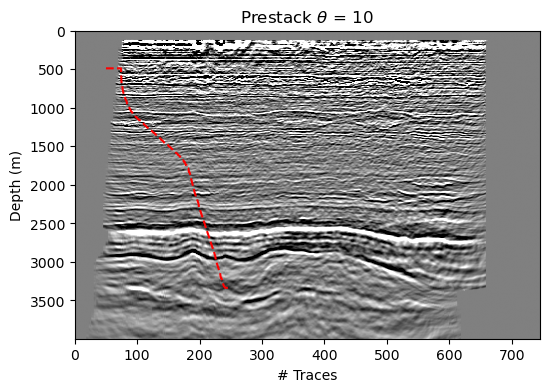

In [4]:
plt.figure(figsize=(6,4))
plt.imshow(seismicd_prestack_fence[:,10,:].T, cmap='gray', vmin=-1, vmax=1,
           extent=[0, seismicd_prestack_fence.shape[0], 
                   z_seismic_prestack_fence[-1], 
                   z_seismic_prestack_fence[0]])
# Plot the well trajectory
plt.plot(np.arange(len(zwell))[50:250], zwell[50:250], '--r')
plt.title('Prestack $\\theta$ = 10')
plt.xlabel('# Traces')
plt.ylabel('Depth (m)')
plt.axis('tight')

Plot the data in offset, angle, and the area of inversion

In [5]:
## Get the window depth for the prestack where the well log has information. 
window_min, window_max, well_start_data, well_end_data = get_depth_window_fence_Volve(well_vp_prestack_sampling=well_vp_prestack_sampling, 
                                                                                      zwell_seismic=zwell_seismic, 
                                                                                      z_seismic_prestack_fence=z_seismic_prestack_fence)

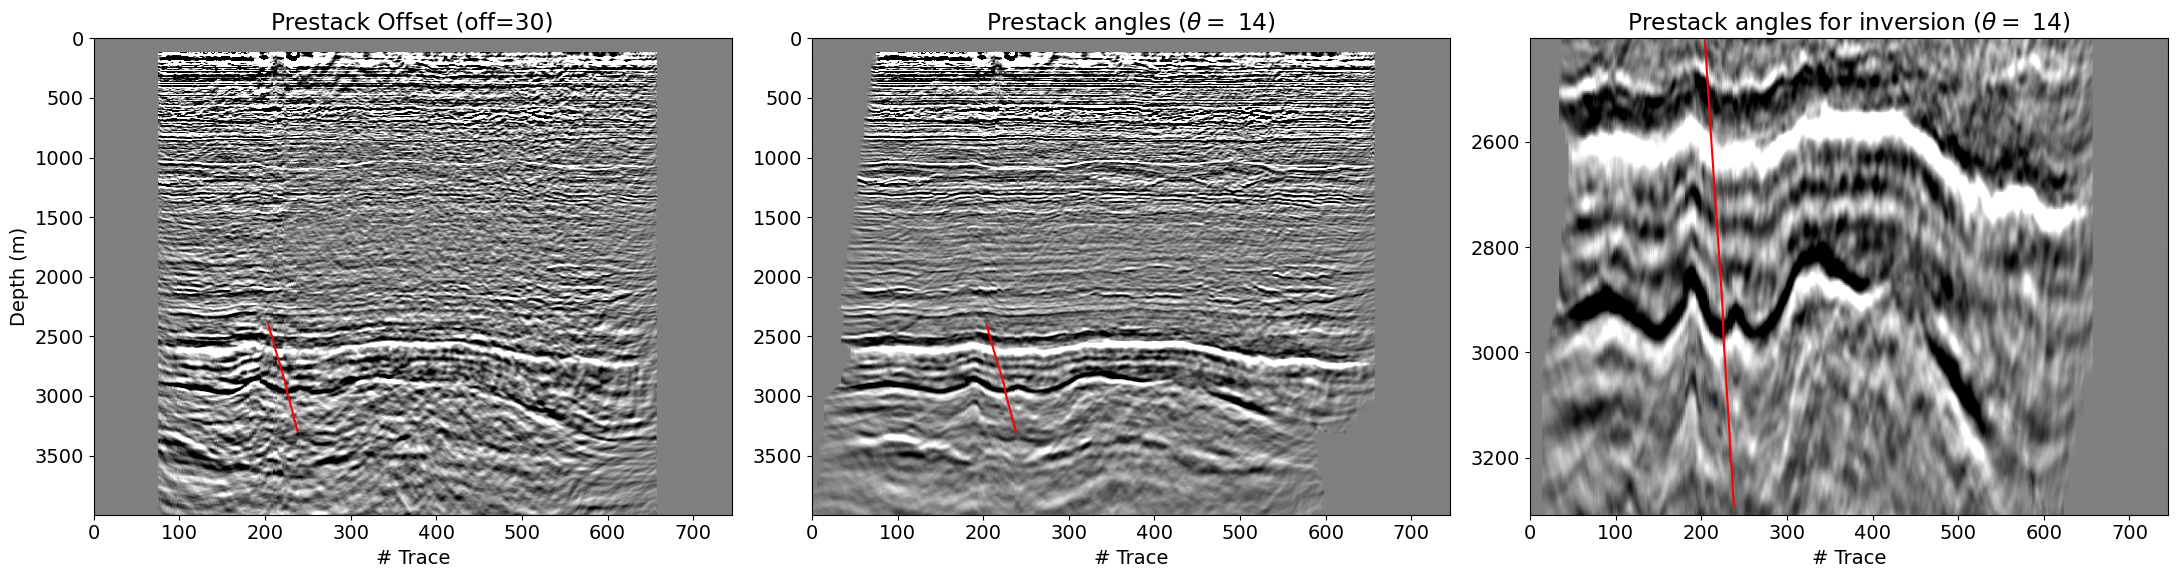

In [6]:
## Plot the data 
fig = plot_Volve_seismic_data(wellname=wellname, offset_num=30, angle=14, 
                            zwell=zwell, z_seismic_prestack_fence=z_seismic_prestack_fence, 
                            window_min=window_min, window_max=window_max, 
                            offset=offset, seismicd_prestack_fence=seismicd_prestack_fence,
                            fontsize=14, title_on=False)

Therefore, the prestack for the inverson is:

In [7]:
d = seismicd_prestack_fence[:,:,window_min:window_max]

In addition, it is necessary to obtain the background models of the fence based on velocity data. These models will serve as our initial guess for the inversion process ($\phi_{bg}$, $\mathrm{Vsh_{bg}}$, and $\mathrm{Sw_{bg}}$). Similarly, the $\mathrm{Vp_{bg}}$, $\mathrm{Vs_{bg}}$, and $\mathrm{\rho_{bg}}$ are needed to create the background AVO synthetic gather $\mathrm{D_b}$

In [8]:
#Smoothing velocity
v_fence_depth = gaussian_filter(v_fence_depth, sigma=60)

# Background models of Elastic parameters 
# Coefficients for the background models
intercept_vp, gradient_vp = -1733.7705987246495, 1.4613508156641841
intercept_vs, gradient_vs = -637.3305563365548, 0.7158182144744273
intercept_rho, gradient_rho = 1.6762212749420877, 0.00020151496167424972


vp_fence_bg = create_background_model(a=gradient_vp, b=intercept_vp, vel = v_fence_depth)
vs_fence_bg = create_background_model(a=gradient_vs, b=intercept_vs, vel = v_fence_depth)
rho_fence_bg = create_background_model(a=gradient_rho, b=intercept_rho, vel =  v_fence_depth)

# ai_fence_bg = vp_fence_bg*rho_fence_bg
# si_fence_bg = vs_fence_bg*rho_fence_bg


# Background models of Petrophysical paramters
# Coefficients for the background models
intercept_phi, gradient_phi = 0.5855599054619403,  -0.00012061601726243674
intercept_vsh, gradient_vsh = 3.2518732973828266, -0.0007709875968411482
intercept_sw, gradient_sw = -0.0758987445846312, 0.0002481488872455055

phi_fence_bg = create_background_model(a=gradient_phi, b=intercept_phi, vel = v_fence_depth)
vsh_fence_bg = create_background_model(a=gradient_vsh, b=intercept_vsh, vel = v_fence_depth)
sw_fence_bg= create_background_model(a=gradient_sw, b=intercept_sw, vel = v_fence_depth)

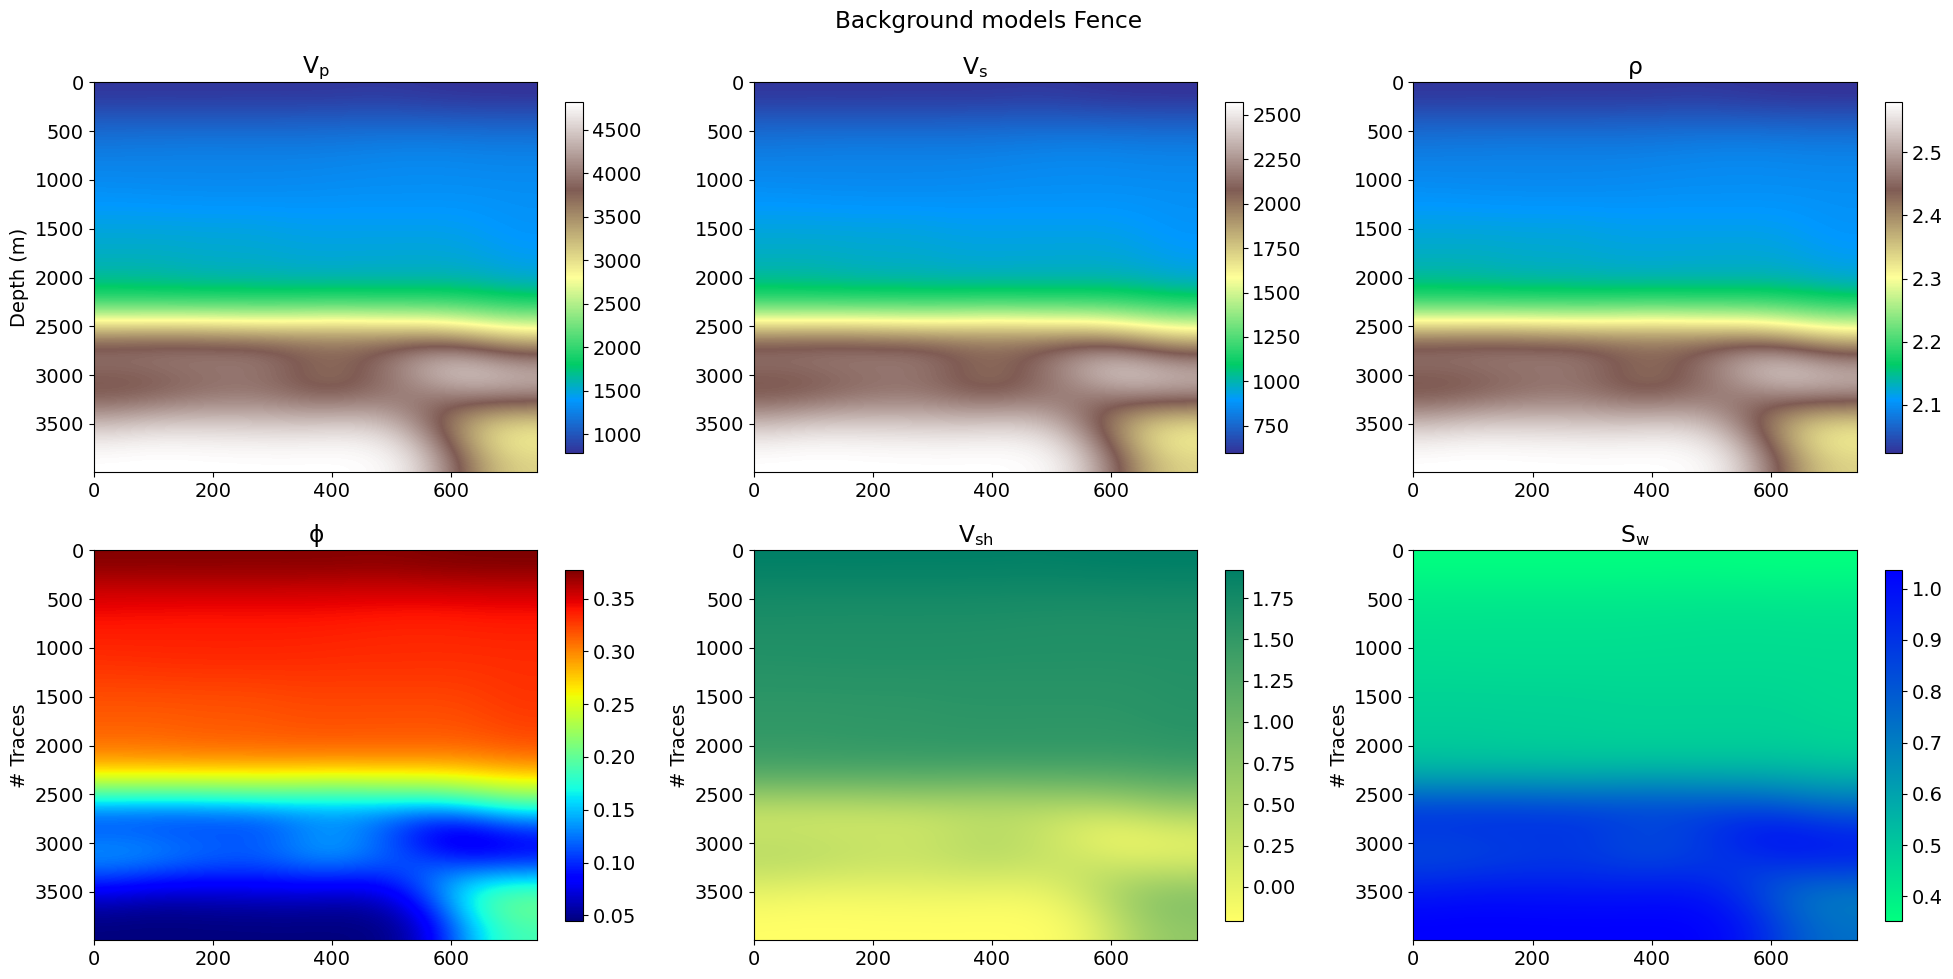

In [9]:
fig = plot_background_models_fence(vp_fence_bg=vp_fence_bg, vs_fence_bg=vs_fence_bg, rho_fence_bg=rho_fence_bg, 
                                 phi_fence_bg=phi_fence_bg, vsh_fence_bg=vsh_fence_bg, sw_fence_bg=sw_fence_bg, 
                                 seismicd_prestack_fence=seismicd_prestack_fence, z_seismic_prestack_fence=z_seismic_prestack_fence)


Furthermore, it is essential to crop the background models to the same window as the prestack data before performing the inversion. 

In [10]:
## Elastic
vp_fence_bg = vp_fence_bg[:,window_min:window_max]
vs_fence_bg = vs_fence_bg[:,window_min:window_max]
rho_fence_bg = rho_fence_bg[:,window_min:window_max]

## Petrophysical
phi_fence_bg = phi_fence_bg[:,window_min:window_max]
vsh_fence_bg = vsh_fence_bg[:,window_min:window_max]
sw_fence_bg = sw_fence_bg[:,window_min:window_max]

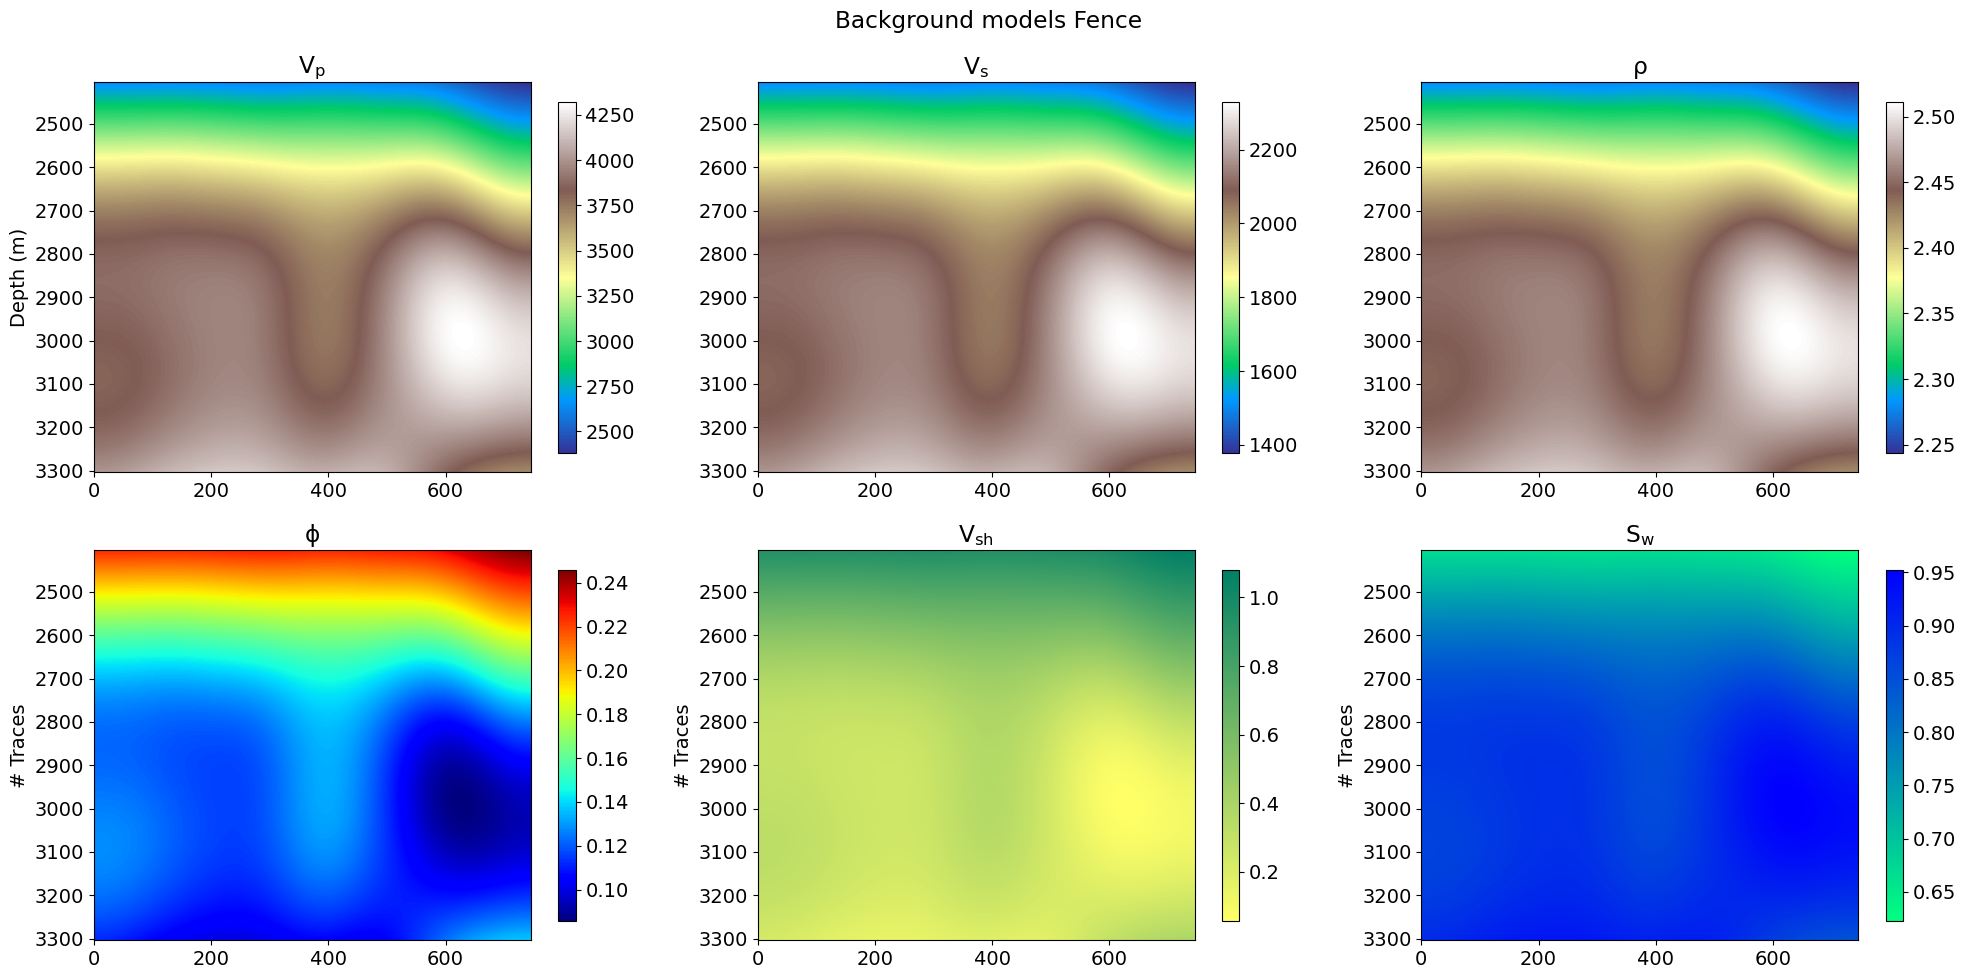

In [11]:
fig = plot_background_models_fence(vp_fence_bg=vp_fence_bg, vs_fence_bg=vs_fence_bg, rho_fence_bg=rho_fence_bg, 
                                 phi_fence_bg=phi_fence_bg, vsh_fence_bg=vsh_fence_bg, sw_fence_bg=sw_fence_bg, 
                                 seismicd_prestack_fence=d, z_seismic_prestack_fence=z_seismic_prestack_fence[window_min:window_max])

### Well log information 

Here, we will present the available well log information, which will be utilized in the subsequent Seis2Rock training process. We first need a bit of cleaning.

In [12]:
#Processing elastic logs
vp, vs, rho, vp_back, vs_back, rho_back = process_well_logs(log_1=well_vp_prestack_sampling, 
                                                            log_2=well_vs_prestack_sampling, 
                                                            log_3=well_rho_prestack_sampling, 
                                                            depth_min=well_start_data, 
                                                            depth_max=well_end_data,
                                                            nsmooth=40)

#If AI and SI logs are needed: 
ai = vp*rho
si = vs*rho

#Processing petrophysical logs
phi, vsh, sw, phi_back, vsh_back, sw_back = process_well_logs(log_1=well_phi_prestack_sampling, 
                                                              log_2=well_vsh_prestack_sampling, 
                                                              log_3=well_sw_prestack_sampling, 
                                                              depth_min=well_start_data, 
                                                              depth_max=well_end_data,
                                                              nsmooth=40)


Plot the well logs available and the prestack data along the well

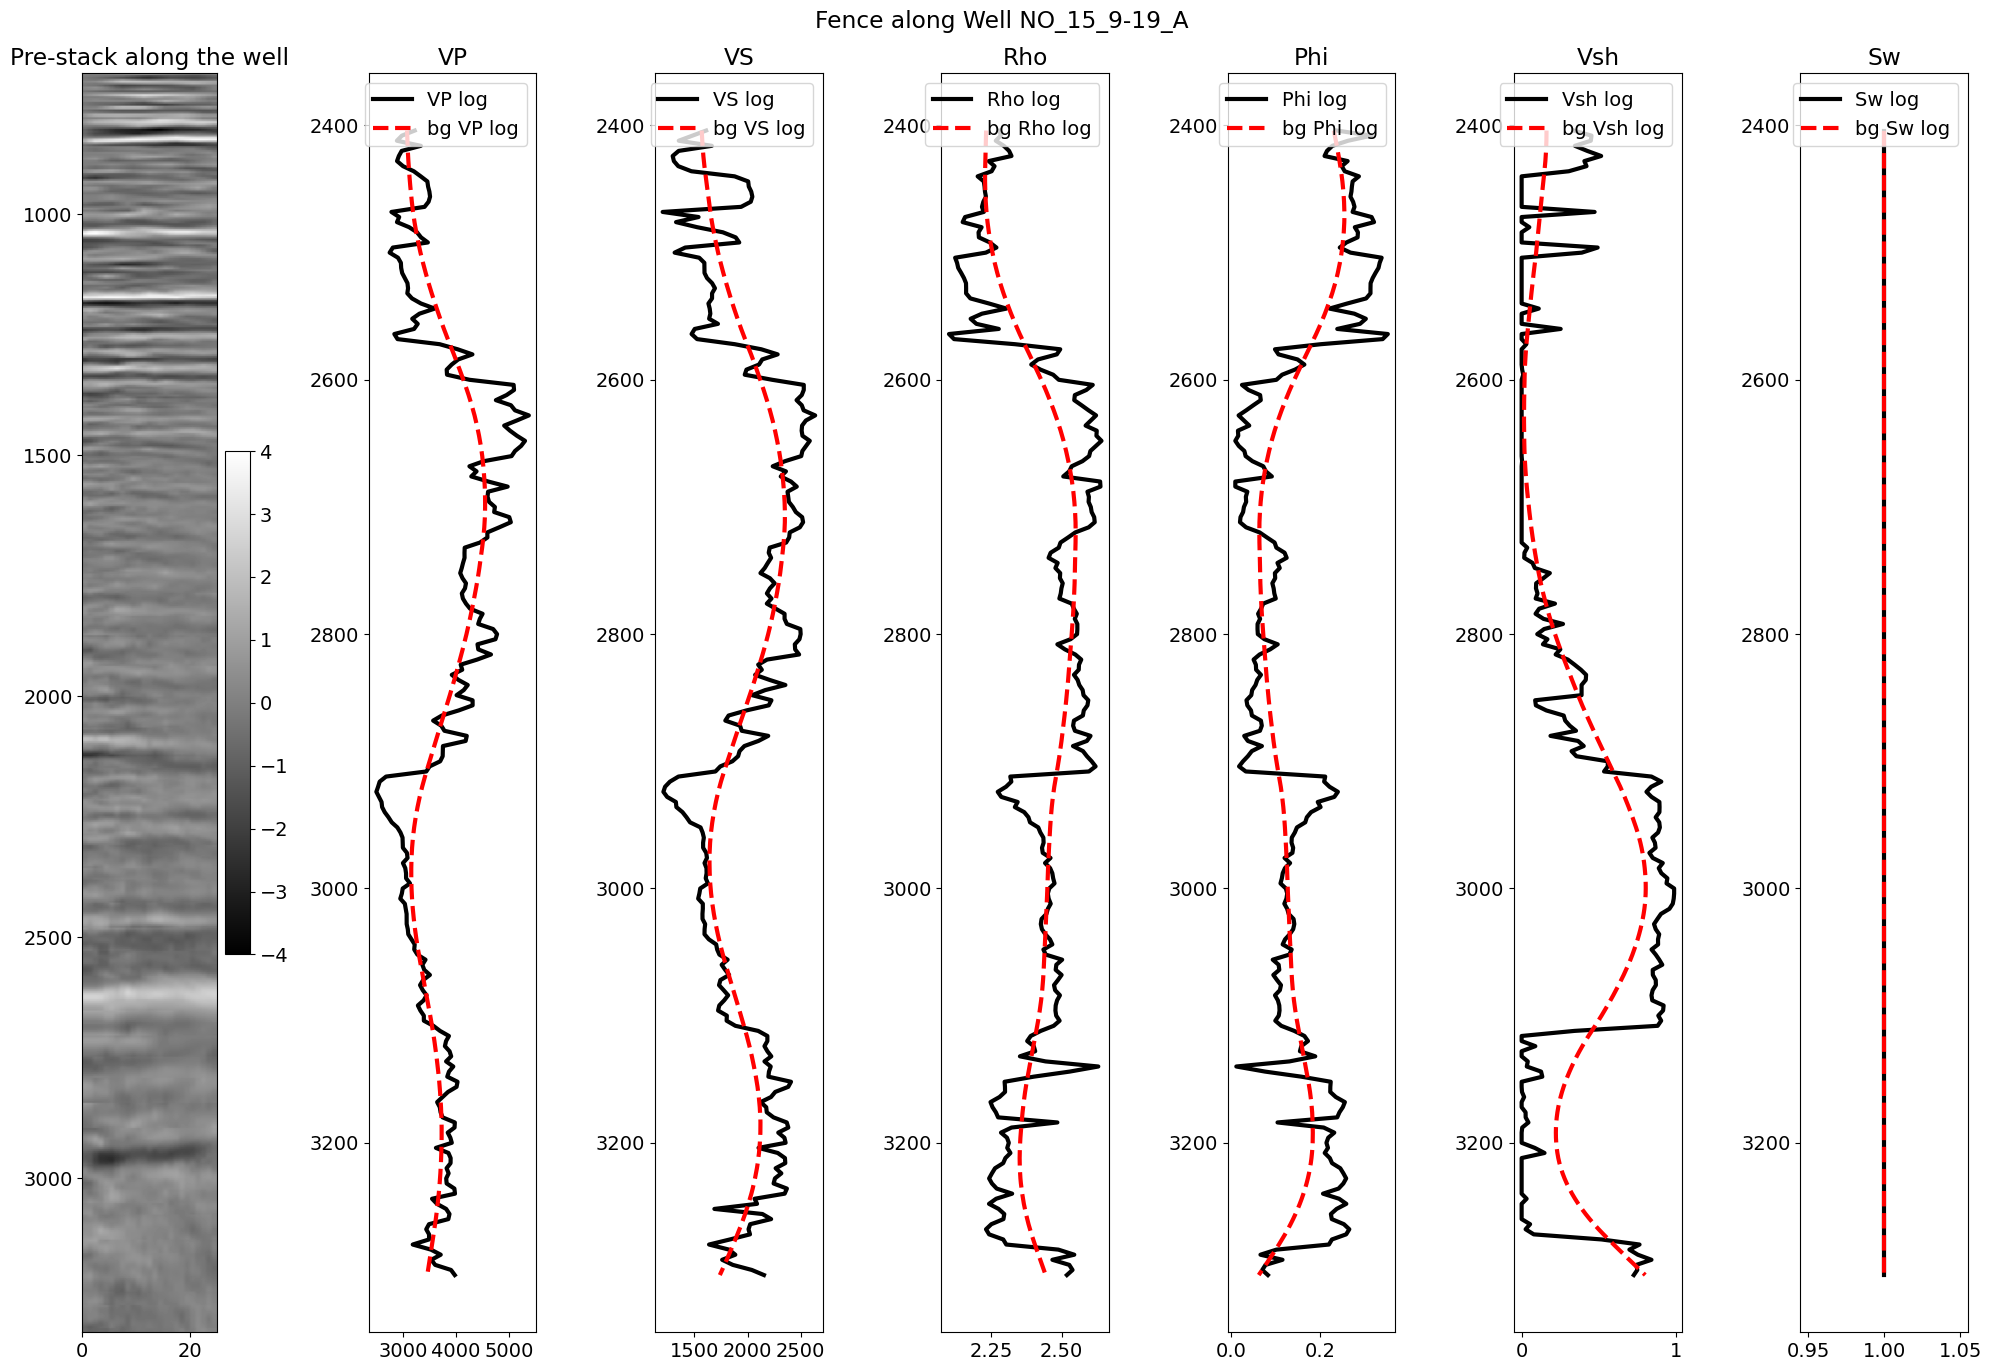

In [13]:
thetamin=0
thetamax=25
ntheta = 25

plot_set_logs(well_name='Fence along Well NO_15_9-19_A', 
              well_prestack=well_prestack, 
              extent_prestack=(thetamin, thetamax, zwell_seismic[-1], zwell_seismic[0]), 
              well_depth=zwell_seismic[well_start_data:well_end_data], 
              vp=vp, 
              vs=vs, 
              rho=rho, 
              phi=phi, 
              vsh=vsh, 
              sw=sw,
              vp_back=vp_back, 
              vs_back=vs_back, 
              rho_back=rho_back,
              phi_back=phi_back, 
              vsh_back=vsh_back, 
              sw_back=sw_back, 
              figsize=(20,14))

### Wavelet estimation

Lastly, we need to acquire the necessary wavelet. This step is crucial for further analysis and processing. Here we use the wavelet scaling obtained in one of the previous notebooks. 

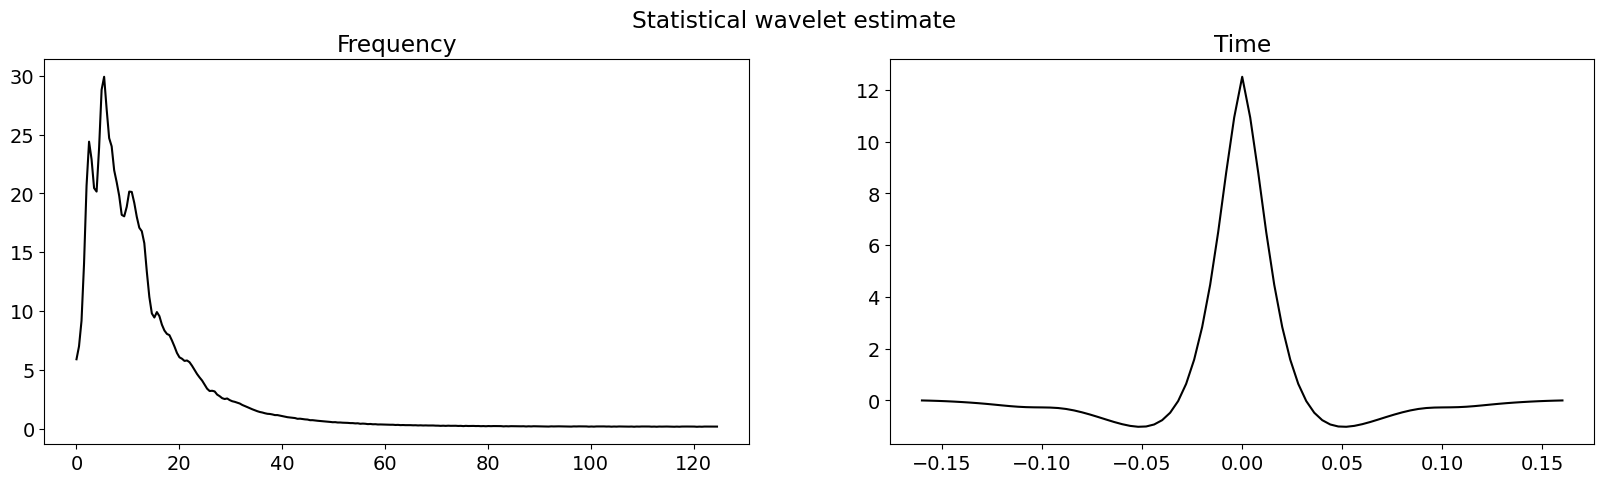

In [14]:
# Statistical Wavelet estimation
nfft = 512
nt_wav = 41
# wav_scaling =18
wav_scaling =12.5

wav_est, t_wav ,fwest, wav_est_fft = get_wavelet_estimate(nt_wav=nt_wav, nfft=nfft, wav_scaling=wav_scaling, 
                                    prestack_data=d, 
                                    dt=dt)


# Display wavelet
display_wavelet(wav_est= wav_est, fwest=fwest, wav_est_fft=wav_est_fft, 
                t_wav= t_wav, nfft=nfft, fontsize = 14)

## Seis2Rock framework

Now, we come to the most exciting part, where we apply the proposed methodology. We begin with the training phase, and it's important to note that we are not training any neural network in this context. The term "training" refers to obtaining the optimal basis functions $\mathrm{Fp}$ learned from the AVO synthetic gather.

In [15]:
# Select number of p optimal coeffcients 
p = 2
Fp, Lp, Vp, F, L, V, r_zoeppritz, r_zoeppritz_back, d_well = Seis2Rock_training(vp=vp, vs=vs, rho=rho, 
                                                                      wav_est=wav_est, nt_wav=nt_wav, 
                                                                      vp_back=vp_back, vs_back=vs_back, rho_back=rho_back, 
                                                                      p=p, 
                                                                      thetamin=0, thetamax=25, ntheta=25)

Computing AVO synthetic gathers from the well logs...
Performing SVD...
Extracting Optimal basis functions Fp..
Done! xD
2


Just to double check, let us look at the singular values

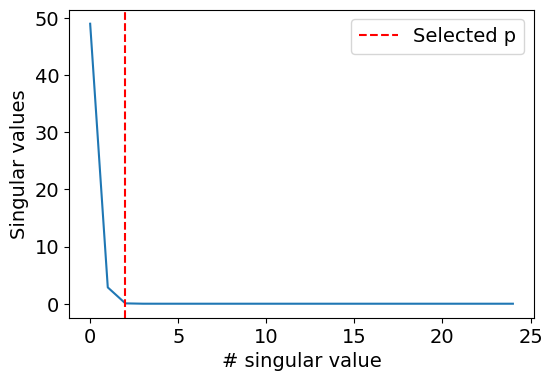

In [16]:
plt.figure(figsize=(6,4))
plt.plot(np.diag(np.abs(L)))
plt.xlabel('# singular value')
plt.ylabel('Singular values')
plt.axvline(x=p, color='r', linestyle='--', label='Selected p')
plt.legend()
plt.axis('tight')
plt.show()

Now, we move on to the inference phase, where we obtain the optimal coefficients $\mathrm{Cp}$ and, consequently, the new data term $\mathrm{B}$, which represents the petrophysical reflectivities.

In [17]:
b_optAVO, r_zoeppritz_back, Cp, Hp, Cp_estimated = Seis2Rock_inference(vp=vp_fence_bg, vs=vs_fence_bg, rho=rho_fence_bg, 
                                                         wav_est=wav_est, nt_wav=nt_wav, dtheta=d, 
                                                         Fp=Fp, Lp=Lp, Vp=Vp, 
                                                         phi=phi, vsh=vsh, sw=sw, 
                                                         phi_back=phi_back, vsh_back=vsh_back, sw_back=sw_back,
                                                         d=d_well, 
                                                         thetamin=0, thetamax=25, ntheta=25)

Computing AVO synthetic gather for background models...
Calculating matrix of optimal coefficients Cp...
Creating the new data term (Petrophysical coefficeints B)...
Done xD !


Now, we just need to perform the series of poststack seismic inversion per parameter

In [18]:
## Series of poststack seismic inversion (one per parameter)
## Here we use B as our 'new data term' which is the petrophysical coefficients

## Creating Post Stack Operator
kind ='forward'
D = pylops.avo.poststack.PoststackLinearModelling(wav_est, nt0=b_optAVO.shape[1], 
                                                  spatdims=b_optAVO.shape[2],explicit=True, kind=kind)

## Creating Regularization (In this case Laplacian Regularization)
D2op  = Laplacian([b_optAVO.shape[1],  b_optAVO.shape[2]], dtype='float64', weights=(1,1000))



## Hyperparameters for optimization
niter = 200
lamba1 = 0.1
damp1 = 4


## Inverting for porosity
phi_inv_dense_reg = regularized_inversion(D, b_optAVO[0].ravel(), Regs=[D2op],
                                    epsRs=[lamba1],x0=(phi_fence_bg.T.ravel()),
                                    **dict(iter_lim=niter, damp=damp1))[0].reshape(phi_fence_bg.T.shape) 

## Inverting for vsh
vsh_inv_dense_reg = regularized_inversion(D, b_optAVO[1].ravel(), Regs=[D2op],
                                    epsRs=[lamba1],x0=(vsh_fence_bg.T.ravel()),
                                    **dict(iter_lim=niter, damp=damp1))[0].reshape(vsh_fence_bg.T.shape) 

## Inverting for sw
sw_inv_dense_reg = regularized_inversion(D, b_optAVO[2].ravel(), Regs=[D2op],
                                    epsRs=[lamba1],x0=sw_fence_bg.T.ravel(),
                                    **dict(iter_lim=niter, damp=damp1))[0].reshape(sw_fence_bg.T.shape) 


Let's see the inversion results along the fence

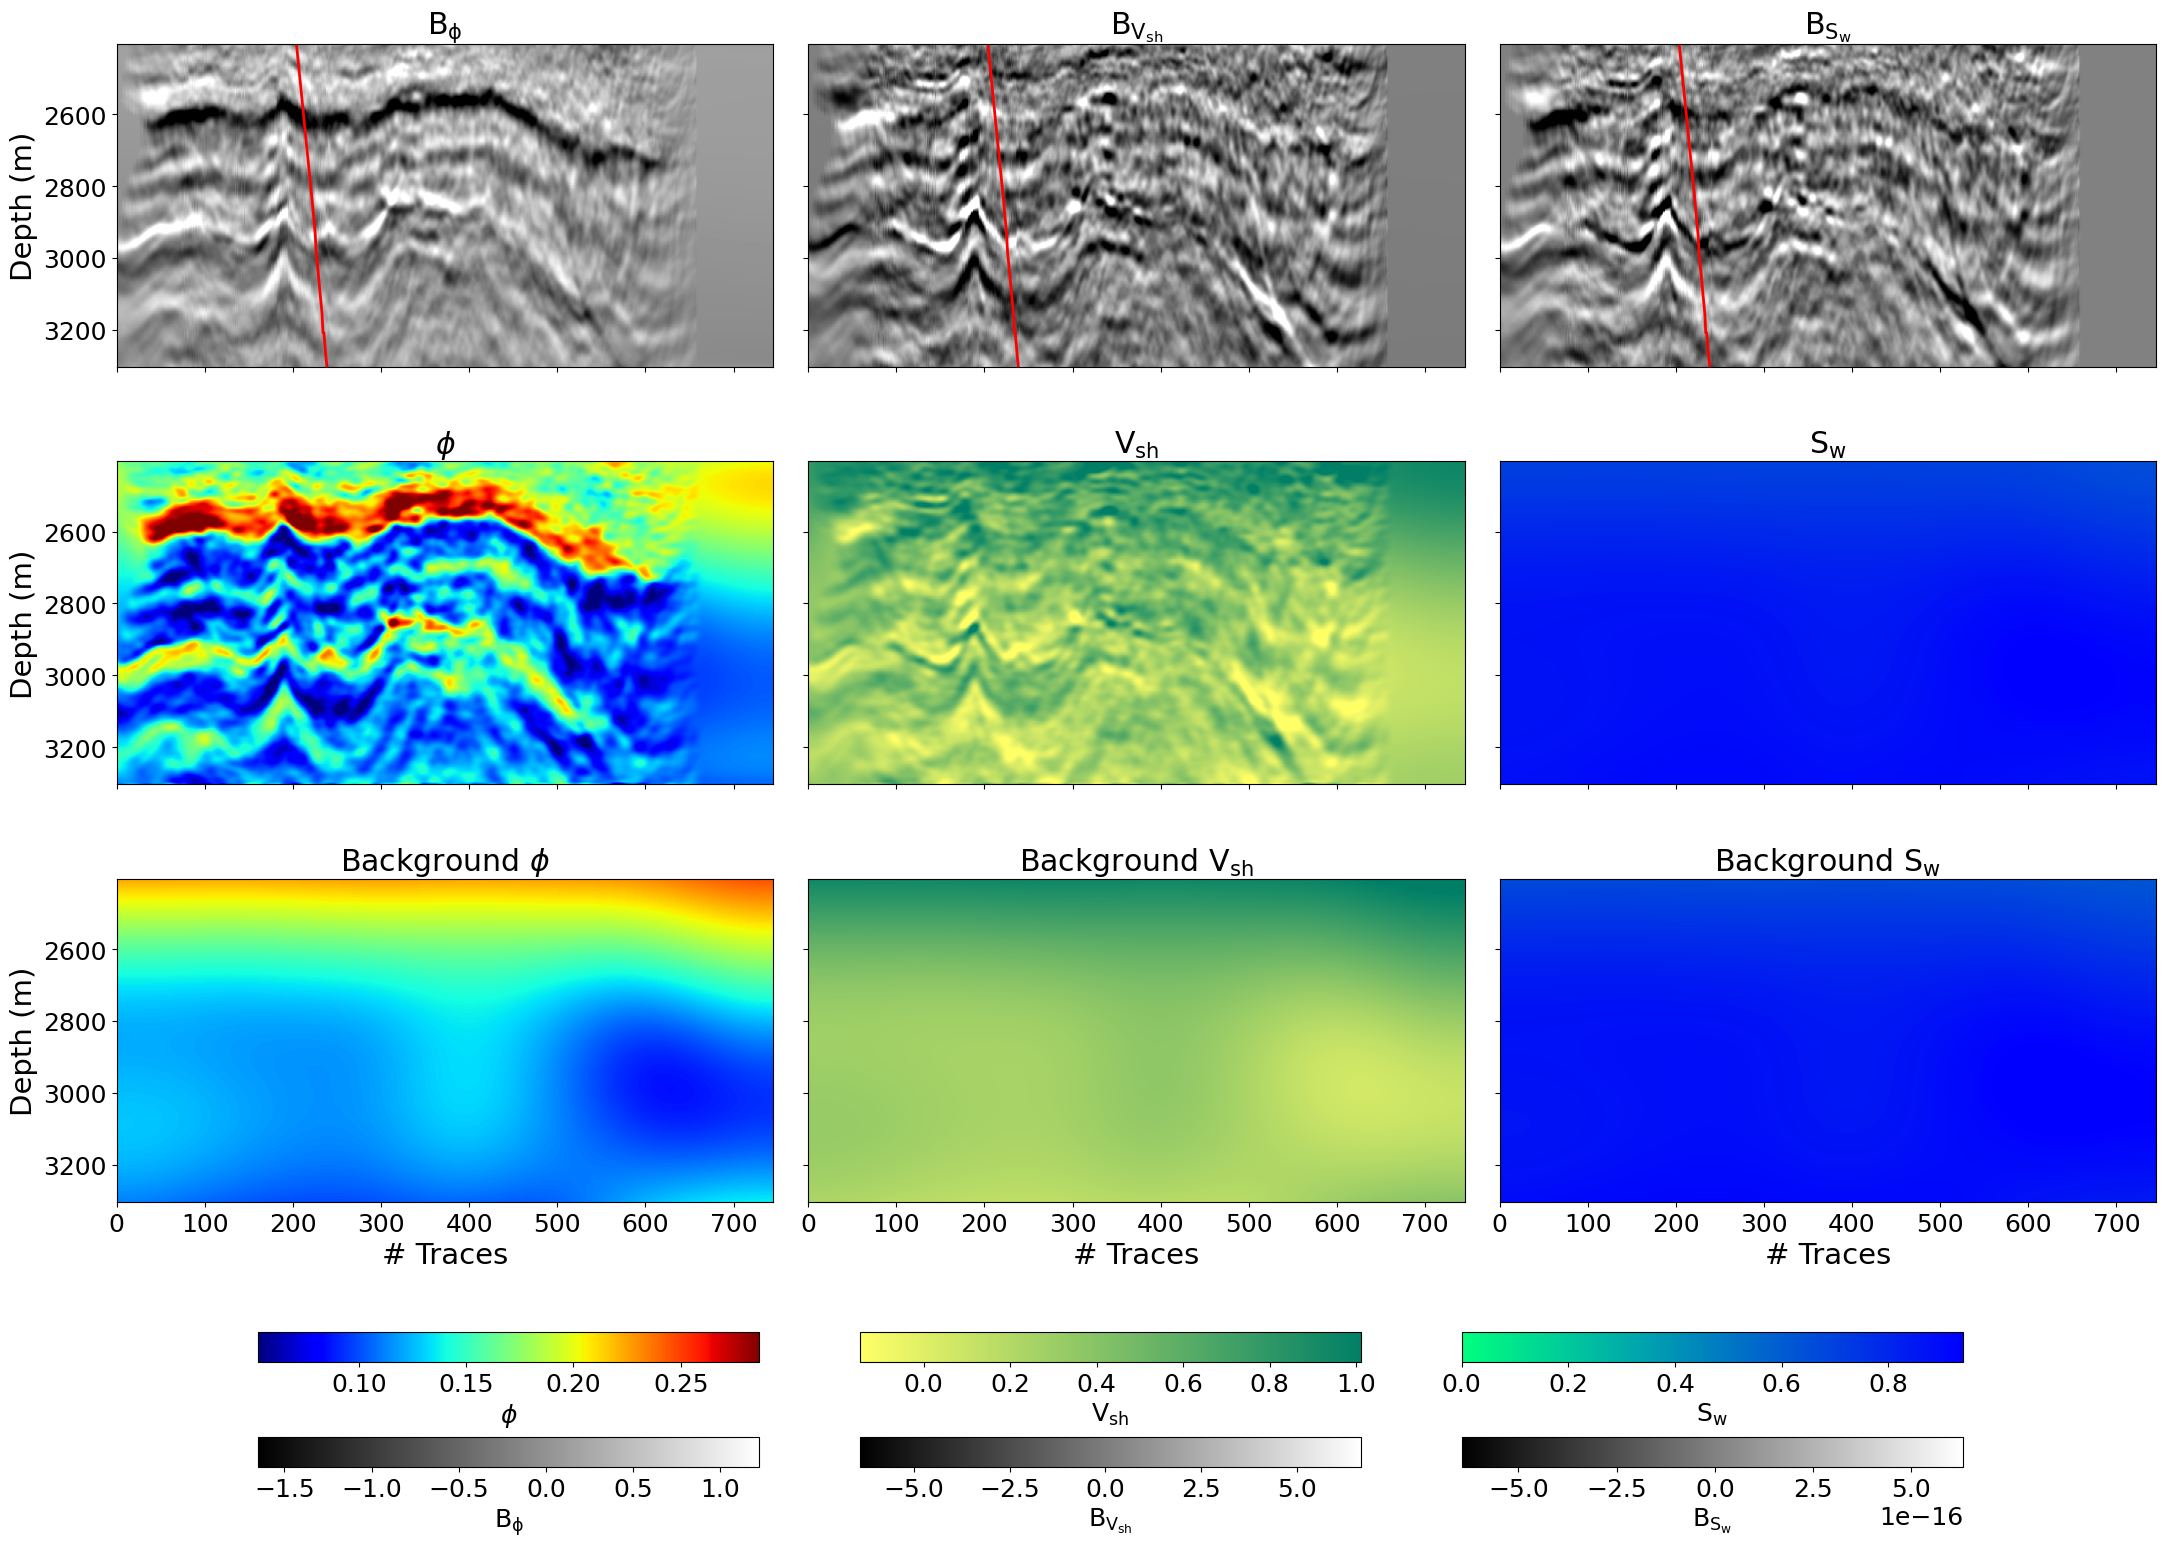

In [19]:
fig = plot_inversion_results_fence(wellname=wellname, prestack_fence=d,
                                   zwell=zwell, z_seismic_prestack_fence=z_seismic_prestack_fence[window_min:window_max], 
                                   phi_inv_dense_reg=phi_inv_dense_reg, 
                                   vsh_inv_dense_reg=vsh_inv_dense_reg, 
                                   sw_inv_dense_reg=sw_inv_dense_reg, 
                                   b_optAVO=b_optAVO,
                                   phi_fence_bg=phi_fence_bg, 
                                   vsh_fence_bg=vsh_fence_bg, 
                                   sw_fence_bg=sw_fence_bg,
                                   fontsize=18,
                                   title_on=False)

# fig.savefig('../../figures_results/inversion_fence_result_well_0.png', format='png', dpi=300, bbox_inches='tight')


And finally, the results on the well

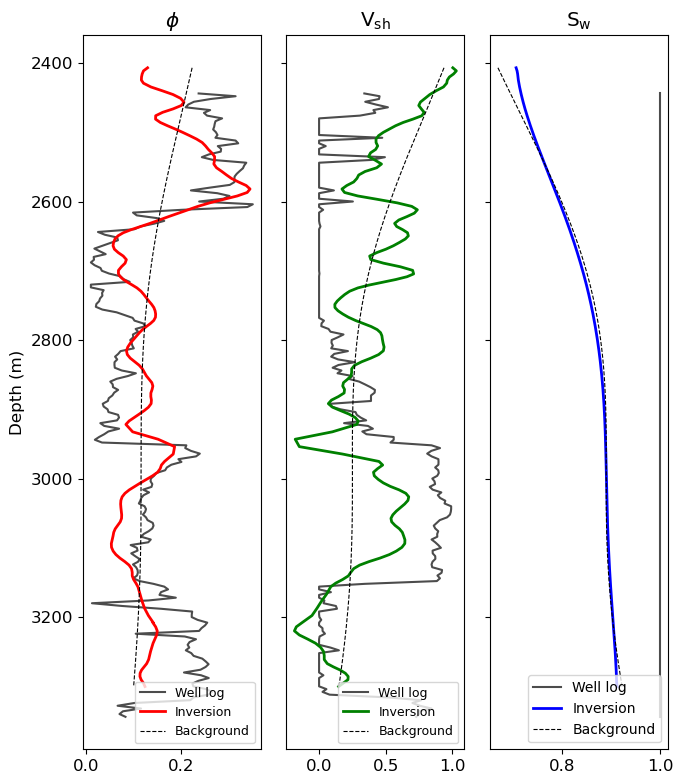

In [20]:
fig = plot_well_results_from_fence(wellname=wellname, zwell_seismic=zwell_seismic,
                                   seismicd_prestack_fence=d, zwell=zwell,
                                   z_seismic_prestack_fence=z_seismic_prestack_fence[window_min:window_max],
                                   phi=phi, vsh=vsh, sw=sw,
                                   well_start_data=well_start_data, well_end_data=well_end_data, 
                                   phi_inv_dense_reg=phi_inv_dense_reg, 
                                   vsh_inv_dense_reg=vsh_inv_dense_reg,
                                   sw_inv_dense_reg= sw_inv_dense_reg,
                                   phi_fence_bg=phi_fence_bg, 
                                   vsh_fence_bg=vsh_fence_bg, 
                                   sw_fence_bg=sw_fence_bg,
                                   shift=40, fontsize=12, title_on=False)

Plotting and shifting the trace

In [21]:
#We have to shift because of the well log and prestack traces disaligment 
shift_number = 12 #Shift obtained in wavelet estimation
phi_shifted = shift(phi, shift=shift_number, cval=phi[0])
vsh_shifted = shift(vsh, shift=shift_number, cval=vsh[0])
sw_shifted = shift(sw, shift=shift_number, cval=sw[0])


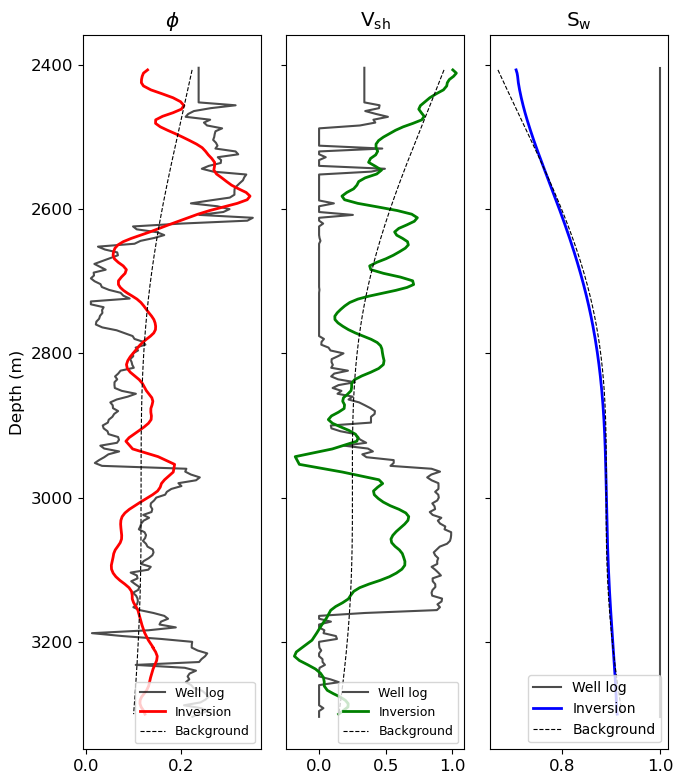

In [22]:
fig = plot_well_results_from_fence(wellname=wellname, zwell_seismic=zwell_seismic,
                                   seismicd_prestack_fence=d, zwell=zwell,
                                   z_seismic_prestack_fence=z_seismic_prestack_fence[window_min:window_max],
                                   phi=phi_shifted, vsh=vsh_shifted, sw=sw_shifted,
                                   well_start_data=well_start_data, well_end_data=well_end_data, 
                                   phi_inv_dense_reg=phi_inv_dense_reg, 
                                   vsh_inv_dense_reg=vsh_inv_dense_reg,
                                   sw_inv_dense_reg= sw_inv_dense_reg,
                                   phi_fence_bg=phi_fence_bg, 
                                   vsh_fence_bg=vsh_fence_bg, 
                                   sw_fence_bg=sw_fence_bg,
                                   shift=0, fontsize=12, title_on=False)